In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('quantium_task1_cleaned.csv')

In [3]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['ID_MONTH'] = df['DATE'].dt.strftime('%Y%m')
df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,ID_MONTH
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural Chip Co,201810
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150.0,Red Rock Deli,201809
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210.0,Grain Waves,201903
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175.0,Natural Chip Co,201903
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160.0,Woolworths,201811


In [4]:
agg_df = (
    df.groupby(['STORE_NBR', 'ID_MONTH'])
    .agg(
        TOTAL_SALES=('TOT_SALES', 'sum'),              # total sales in $
        NUM_CUSTOMERS=('LYLTY_CARD_NBR', 'nunique'),    # distinct customers
        NUM_TXNS=('TXN_ID', 'nunique'),                # distinct transactions
        TOTAL_QTY=('PROD_QTY', 'sum'),                 # total units of chips sold
    )
    .reset_index()
)

# Transactions per customer
agg_df['TXN_PER_CUSTOMER'] = agg_df['NUM_TXNS'] / agg_df['NUM_CUSTOMERS']

# Chips per customer
agg_df['CHIPS_PER_CUSTOMER'] = agg_df['TOTAL_QTY'] / agg_df['NUM_CUSTOMERS']

# Average price per unit = total sales / total quantity
agg_df['AVG_PRICE_PER_UNIT'] = agg_df['TOTAL_SALES'] / agg_df['TOTAL_QTY']

agg_df.head()

,STORE_NBR,ID_MONTH,TOTAL_SALES,NUM_CUSTOMERS,NUM_TXNS,TOTAL_QTY,TXN_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT
0,1,201807,174.9,43,45,53,1.046512,1.232558,3.300000
1,1,201808,150.1,38,38,48,1.000000,1.263158,3.127083
2,1,201809,228.3,51,52,61,1.019608,1.196078,3.742623
3,1,201810,171.8,37,38,49,1.027027,1.324324,3.506122
4,1,201811,163.6,38,39,49,1.026316,1.289474,3.338776


In [5]:
len(agg_df['STORE_NBR'].unique())

271

In [6]:
stores_with_full_obs = (
    agg_df.groupby("STORE_NBR")["ID_MONTH"]
    .nunique()
    .reset_index()
)
stores_with_full_obs = stores_with_full_obs.loc[stores_with_full_obs["ID_MONTH"] == 12, "STORE_NBR"]

# Step 2: Filter to pre-trial period (< 201902) and those stores
pre_trial_measures = agg_df[
    (agg_df["ID_MONTH"].astype(int) < 201902) & 
    (agg_df["STORE_NBR"].isin(stores_with_full_obs))
]

pre_trial_measures.head()

,STORE_NBR,ID_MONTH,TOTAL_SALES,NUM_CUSTOMERS,NUM_TXNS,TOTAL_QTY,TXN_PER_CUSTOMER,CHIPS_PER_CUSTOMER,AVG_PRICE_PER_UNIT
0,1,201807,174.9,43,45,53,1.046512,1.232558,3.300000
1,1,201808,150.1,38,38,48,1.000000,1.263158,3.127083
2,1,201809,228.3,51,52,61,1.019608,1.196078,3.742623
3,1,201810,171.8,37,38,49,1.027027,1.324324,3.506122
4,1,201811,163.6,38,39,49,1.026316,1.289474,3.338776


In [7]:
len(pre_trial_measures['STORE_NBR'].unique())

259

We have reduced the number of stores based on our filtering

## Functions for "TOTAL_SALES" & "NUM_CUSTOMERS" Analysis

In [8]:
def calculate_similarity(input_table, metric_col, store_comparison, corr_weight=0.5):
    """
    input_table: DataFrame with columns ['STORE_NBR', 'ID_MONTH', metric_col]
    metric_col: str, the column to calculate correlation and distance on
    store_comparison: int, the trial store number
    corr_weight: float, weight for correlation in combined score (default=0.5)
    """
    results = []
    store_numbers = input_table['STORE_NBR'].unique()
    store_numbers = [s for s in store_numbers if s != store_comparison]

    # Pivot so each store is a column for easier alignment
    pivot_df = input_table.pivot(index='ID_MONTH', columns='STORE_NBR', values=metric_col)

    trial_series = pivot_df[store_comparison]

    for store in store_numbers:
        control_series = pivot_df[store]

        # Align on common months
        aligned = pd.concat([trial_series, control_series], axis=1, join='inner').dropna()
        aligned.columns = ['trial', 'control']

        if len(aligned) > 1:
            # Correlation (remains the same)
            corr = aligned['trial'].corr(aligned['control'], method='pearson')

            # New monthly magnitude calculation
            monthly_diffs = (aligned['trial'] - aligned['control']).abs()
            
            # Standardize monthly differences per month
            monthly_min = monthly_diffs.min()
            monthly_max = monthly_diffs.max()
            if monthly_max > monthly_min:
                monthly_similarities = 1 - (monthly_diffs - monthly_min) / (monthly_max - monthly_min)
            else:
                monthly_similarities = pd.Series(1, index=monthly_diffs.index)
            
            # Average standardized monthly similarities
            magnitude_similarity = monthly_similarities.mean()
        else:
            corr, magnitude_similarity = None, None

        results.append({
            'Store1': store_comparison,
            'Store2': store,
            'corr_measure': corr,
            'magnitude_similarity': magnitude_similarity
        })

    corr_table = pd.DataFrame(results)

    # Final combined score (using magnitude_similarity directly)
    corr_table['score'] = (
        corr_weight * corr_table['corr_measure'].fillna(0) +
        (1 - corr_weight) * corr_table['magnitude_similarity'].fillna(0)
    )

    return corr_table

In [9]:
def plot_store_comparison(input_table, trial_store, control_store, metric_col, cutoff=201903):
    """
    Plot monthly trends for a given metric, comparing Trial vs Control vs Other stores.
    
    input_table: DataFrame with columns ['STORE_NBR', 'ID_MONTH', metric_col]
    trial_store: int, store number chosen as trial
    control_store: int, store number chosen as control
    metric_col: str, column to plot (e.g., 'TOTAL_SALES', 'NUM_CUSTOMERS')
    cutoff: int, yearmonth cutoff (default=201903) to filter pre-trial
    """

    df = input_table.copy()

    # Ensure ID_MONTH is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['ID_MONTH']):
        df['ID_MONTH'] = pd.to_datetime(df['ID_MONTH'].astype(str), format="%Y%m")

    # Convert cutoff to datetime for comparison
    cutoff_dt = pd.to_datetime(str(cutoff), format="%Y%m")

    # Assign store type
    df["Store_type"] = df["STORE_NBR"].apply(
        lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
    )

    # Filter pre-trial period
    past = df[df['ID_MONTH'] < cutoff_dt]

    # Aggregate mean metric by month and store type
    past_agg = (
        past.groupby(["ID_MONTH", "Store_type"])[metric_col]
        .mean()
        .reset_index()
    )

    # Plot
    plt.figure(figsize=(10, 6))
    for store_type, group in past_agg.groupby("Store_type"):
        plt.plot(group["ID_MONTH"], group[metric_col], label=store_type)

    plt.xlabel("Month of operation")
    plt.ylabel(metric_col.replace("_", " ").title())
    plt.title(f"{metric_col.replace('_', ' ').title()} by month")
    plt.legend()
    plt.grid(True)
    
    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

In [10]:
from scipy.stats import t

def calculate_scaling_factor(data, trial_store, control_store, metric_col, pre_start, pre_end):
    """Calculate scaling factor based on pre-trial period totals."""
    # Convert pre_start and pre_end to datetime if they are integers
    if isinstance(pre_start, int):
        pre_start = datetime.strptime(str(pre_start), '%Y%m')
    if isinstance(pre_end, int):
        pre_end = datetime.strptime(str(pre_end), '%Y%m')
    
    trial_sales = data[(data['STORE_NBR'] == trial_store) & 
                       (data['ID_MONTH'].between(pre_start, pre_end))][metric_col].sum()
    control_sales = data[(data['STORE_NBR'] == control_store) & 
                         (data['ID_MONTH'].between(pre_start, pre_end))][metric_col].sum()
    return trial_sales / control_sales

def calculate_percentage_diff(data, trial_store, control_store, metric_col, scaling_factor, start, end):
    """Calculate percentage difference between trial and scaled control stores for a period."""
    # Convert start and end to datetime if they are integers
    if isinstance(start, int):
        start = datetime.strptime(str(start), '%Y%m')
    if isinstance(end, int):
        end = datetime.strptime(str(end), '%Y%m')
    
    trial_data = data[(data['STORE_NBR'] == trial_store) & 
                      (data['ID_MONTH'].between(start, end))].groupby('ID_MONTH')[metric_col].sum().reset_index()
    control_data = data[(data['STORE_NBR'] == control_store) & 
                        (data['ID_MONTH'].between(start, end))].groupby('ID_MONTH')[metric_col].sum().reset_index()
    control_data['SCALED_CONTROL'] = control_data[metric_col] * scaling_factor
    merged = pd.merge(trial_data, control_data, on='ID_MONTH', suffixes=('_TRIAL', '_CONTROL'))
    merged['PERCENTAGE_DIFF'] = (merged[metric_col + '_TRIAL'] - merged['SCALED_CONTROL']) / merged['SCALED_CONTROL'] * 100
    return merged[['ID_MONTH', metric_col + '_TRIAL', 'SCALED_CONTROL', 'PERCENTAGE_DIFF']]

def t_test_trial_uplift(data, trial_store, control_store, metric_col,
                        trial_start=201902, trial_end=201904, pre_start=None):
    """Perform t-test on trial period uplift using scaled control store."""
    df = data.copy()
    
    # Convert ID_MONTH to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['ID_MONTH']):
        df['ID_MONTH'] = pd.to_datetime(df['ID_MONTH'].astype(str), format='%Y%m')
    
    # Determine pre-trial period
    pre_start = pre_start if pre_start else df['ID_MONTH'].min()
    pre_end = trial_start - 1 if isinstance(trial_start, int) else \
              trial_start - pd.DateOffset(months=1)
    
    # Calculate scaling factor from pre-trial period
    scaling_factor = calculate_scaling_factor(df, trial_store, control_store, metric_col, pre_start, pre_end)
    
    # Calculate percentage differences for pre-trial and trial periods
    pre_trial_diff = calculate_percentage_diff(df, trial_store, control_store, metric_col, scaling_factor, pre_start, pre_end)
    trial_diff = calculate_percentage_diff(df, trial_store, control_store, metric_col, scaling_factor, trial_start, trial_end)
    
    # Calculate std deviation and degrees of freedom from pre-trial
    std_dev = pre_trial_diff['PERCENTAGE_DIFF'].std()
    n_pre = len(pre_trial_diff)
    df_deg = n_pre - 1
    
    # Calculate t-values for trial period
    trial_diff['tValue'] = trial_diff['PERCENTAGE_DIFF'] / (std_dev / (n_pre ** 0.5))
    
    # Determine significance
    t_critical = t.ppf(0.95, df_deg)
    trial_diff['Significant'] = trial_diff['tValue'].abs() > t_critical
    
    return trial_diff, t_critical, std_dev

In [11]:
def plot_trial_vs_control(data, trial_store, control_store, metric_col, 
                         trial_start=datetime(2019, 2, 1), trial_end=datetime(2019, 4, 30)):
    # Ensure ID_MONTH is datetime
    df = data.copy()
    if not pd.api.types.is_datetime64_any_dtype(df['ID_MONTH']):
        df['ID_MONTH'] = pd.to_datetime(df['ID_MONTH'].astype(str), format='%Y%m')
    
    # Convert trial dates to datetime if they're integers
    if isinstance(trial_start, int):
        trial_start = datetime.strptime(str(trial_start), '%Y%m')
    if isinstance(trial_end, int):
        trial_end = datetime.strptime(str(trial_end), '%Y%m')
    
    # Calculate pre-trial period
    pre_start = df['ID_MONTH'].min()
    pre_end = trial_start - pd.DateOffset(months=1)
    
    # Calculate scaling factor
    scaling_factor = calculate_scaling_factor(
        df, trial_store, control_store, metric_col, pre_start, pre_end
    )
    
    # Get all months data for both stores
    trial_data = df[df['STORE_NBR'] == trial_store].copy()
    control_data = df[df['STORE_NBR'] == control_store].copy()
    
    # Scale control data
    control_data['SCALED_SALES'] = control_data[metric_col] * scaling_factor
    
    # Calculate std deviation from pre-trial period
    pre_trial_diff = calculate_percentage_diff(
        df, trial_store, control_store, metric_col, scaling_factor, pre_start, pre_end
    )
    std_dev = pre_trial_diff['PERCENTAGE_DIFF'].std() / 100  # Convert percentage to decimal
    
    # Prepare data for plotting
    plot_df = pd.concat([
        trial_data[['ID_MONTH', metric_col]].assign(Store_type='Trial'),
        control_data[['ID_MONTH', 'SCALED_SALES']].rename(
            columns={'SCALED_SALES': metric_col}
        ).assign(Store_type='Control')
    ])
    
    # Calculate confidence intervals
    control_95 = control_data[['ID_MONTH', 'SCALED_SALES']].copy()
    control_95[metric_col] = control_95['SCALED_SALES'] * (1 + 2 * std_dev)
    control_95['Store_type'] = 'Control 95th % CI'
    
    control_5 = control_data[['ID_MONTH', 'SCALED_SALES']].copy()
    control_5[metric_col] = control_5['SCALED_SALES'] * (1 - 2 * std_dev)
    control_5['Store_type'] = 'Control 5th % CI'
    
    plot_df = pd.concat([plot_df, control_95, control_5])
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Plot lines for each store type
    for store_type in plot_df['Store_type'].unique():
        subset = plot_df[plot_df['Store_type'] == store_type]
        plt.plot(subset['ID_MONTH'], subset[metric_col], 
                label=store_type, linewidth=2)
    
    # Highlight trial period
    plt.axvspan(trial_start, trial_end, alpha=0.2, color='grey', label='Trial Period')
    
    # Format plot
    plt.title('Total Sales by Month')
    plt.xlabel('Month of Operation')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

## Store 77

In [12]:
similarity_table = calculate_similarity(pre_trial_measures, "TOTAL_SALES", store_comparison=77, corr_weight=0.5)
print(similarity_table.head())

   Store1  Store2  corr_measure  magnitude_similarity     score
0      77       1      0.164063              0.409266  0.286665
1      77       2     -0.196624              0.449505  0.126441
2      77       3      0.763301              0.450379  0.606840
3      77       4     -0.458373              0.709556  0.125591
4      77       5     -0.113066              0.375098  0.131016


In [13]:
similarity_table = calculate_similarity(pre_trial_measures, "NUM_CUSTOMERS", store_comparison=77, corr_weight=0.5)
similarity_table = similarity_table.sort_values("score", ascending=False)
print(similarity_table.head())

     Store1  Store2  corr_measure  magnitude_similarity     score
219      77     233      0.943213              0.714286  0.828750
81       77      88      0.883831              0.607143  0.745487
105      77     113      0.878670              0.591837  0.735253
110      77     119      0.974600              0.476190  0.725395
148      77     157      0.811107              0.607143  0.709125


### Total Sales Analysis

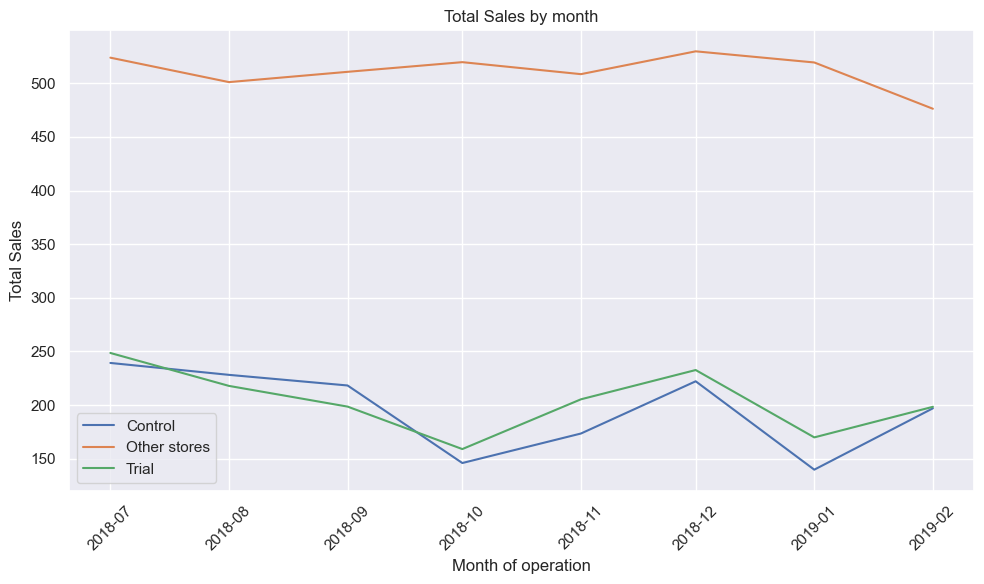

In [14]:
# 46 looks closer to 77 even though it has the 2nd largest score for total sales, but we will go with 219 for now
plot_store_comparison(agg_df, trial_store=77, control_store=233, metric_col="TOTAL_SALES")

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns

def plot_store_comparison_2(input_table, trial_store, control_store, metric_col, cutoff=201903):
    """
    Plot monthly trends for a given metric, comparing Trial vs Control vs Other stores.
    
    input_table: DataFrame with columns ['STORE_NBR', 'ID_MONTH', metric_col]
    trial_store: int, store number chosen as trial
    control_store: int, store number chosen as control
    metric_col: str, column to plot (e.g., 'TOTAL_SALES', 'NUM_CUSTOMERS')
    cutoff: int, yearmonth cutoff (default=201903) to filter pre-trial
    """
    df = input_table.copy()

    # Ensure ID_MONTH is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['ID_MONTH']):
        df['ID_MONTH'] = pd.to_datetime(df['ID_MONTH'].astype(str), format="%Y%m")

    # Convert cutoff to datetime for comparison
    cutoff_dt = pd.to_datetime(str(cutoff), format="%Y%m")

    # Assign store type
    df["Store_type"] = df["STORE_NBR"].apply(
        lambda x: "Trial" if x == trial_store else ("Control" if x == control_store else "Other stores")
    )

    # Filter pre-trial period
    past = df[df['ID_MONTH'] < cutoff_dt]

    # Aggregate mean metric by month and store type
    past_agg = (
        past.groupby(["ID_MONTH", "Store_type"])[metric_col]
        .mean()
        .reset_index()
    )

    # Create figure and axis with white background
    fig, ax = plt.subplots(figsize=(16, 9))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.set_ylabel("Sales")
    
    # Use crest palette for colors
    crest_pal = sns.color_palette("crest", 3)
    store_types = ["Trial", "Control", "Other stores"]
    colors = dict(zip(store_types, crest_pal))

    # Plot each store type
    for store_type in store_types:
        subset = past_agg[past_agg["Store_type"] == store_type]
        ax.plot(subset["ID_MONTH"], subset[metric_col], 
                label=store_type, color=colors[store_type], linewidth=5)

    # Add horizontal black line along x-axis
    min_date = past_agg["ID_MONTH"].min()
    max_date = past_agg["ID_MONTH"].max()
    ax.axhline(y=0, color='black', linewidth=1, linestyle='-', zorder=1)

    # Format y-axis with dollar signs and set limit
    ax.set_ylim(0, 700)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:.0f}'))

    # Format x-axis to show month abbreviations
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

    # Create custom legend boxes
    box_w, box_h, spacing = 0.14, 0.06, 0.007
    start_x = (1 - (3 * box_w + 2 * spacing)) / 2
    legend_y = -0.18

    for i, store_type in enumerate(store_types):
        ax.add_patch(mpatches.FancyBboxPatch(
            (start_x + i * (box_w + spacing), legend_y),
            box_w, box_h,
            boxstyle="round,pad=0.002",
            facecolor=colors[store_type],
            edgecolor="none", 
            transform=ax.transAxes,
            clip_on=False
        ))
        ax.text(start_x + i * (box_w + spacing) + box_w / 2,
                legend_y + box_h / 2,
                store_type,
                va="center", ha="center",
                fontsize=9,
                color='white',
                weight='bold',
                transform=ax.transAxes,
                clip_on=False)

    # Remove grid and extra spines, but keep the bottom spine
    ax.grid(False)
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    
    # Ensure bottom spine is visible and black
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(1)

    # Adjust layout to make room for legend
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.show()

    # fig.savefig("Trial & Control Store",
    # dpi=300,                            # image resolution
    # bbox_inches=None,                # trim extra whitespace
    # pad_inches=0.02,                    # small padding
    # transparent=True) 

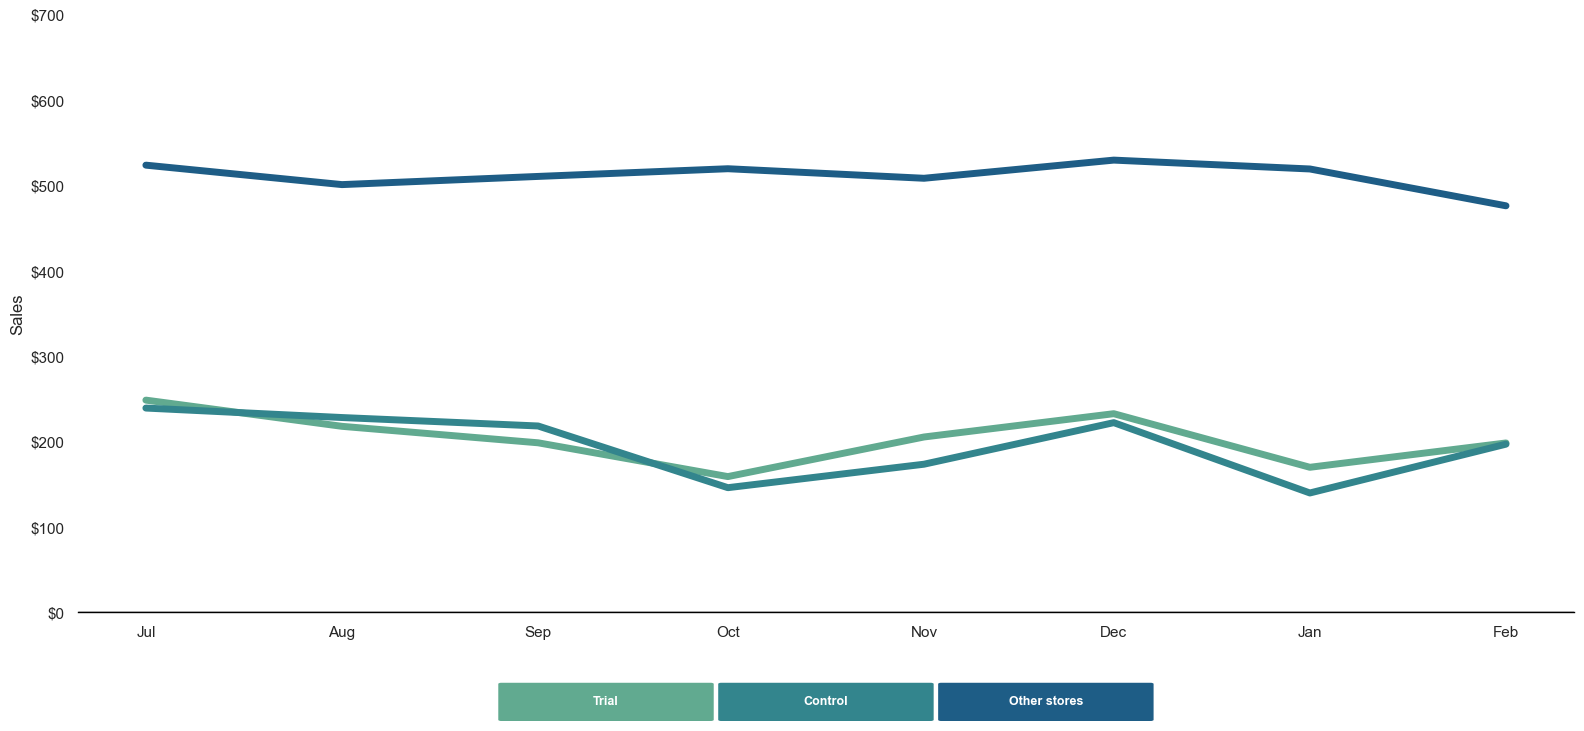

In [16]:
plot_store_comparison_2(agg_df, trial_store=77, control_store=233, metric_col="TOTAL_SALES")

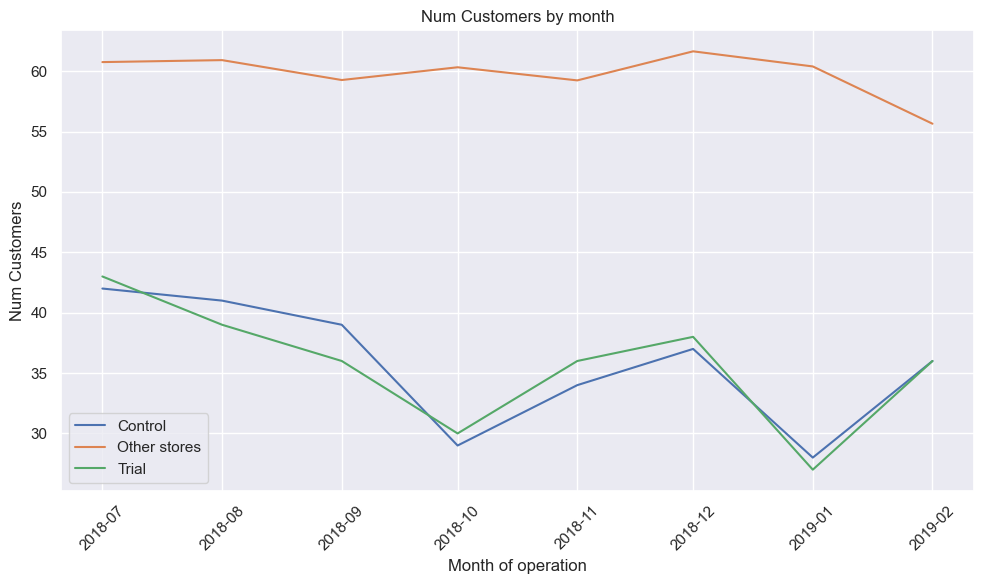

In [17]:
plot_store_comparison(agg_df, trial_store=77, control_store=233, metric_col="NUM_CUSTOMERS")

In [18]:
trial_store = 77
control_store = 233

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="TOTAL_SALES")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

    ID_MONTH  TOTAL_SALES_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01              198.4      206.336356        -3.846320  -0.956601   
1 2019-03-01              237.8      174.390880        36.360342   9.043020   
2 2019-04-01              242.8      136.370526        78.044338  19.410062   

   Significant  
0        False  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


    ID_MONTH  TOTAL_SALES_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01              198.4      206.336356        -3.846320  -0.956601   
1 2019-03-01              237.8      174.390880        36.360342   9.043020   
2 2019-04-01              242.8      136.370526        78.044338  19.410062   

   Significant  
0        False  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


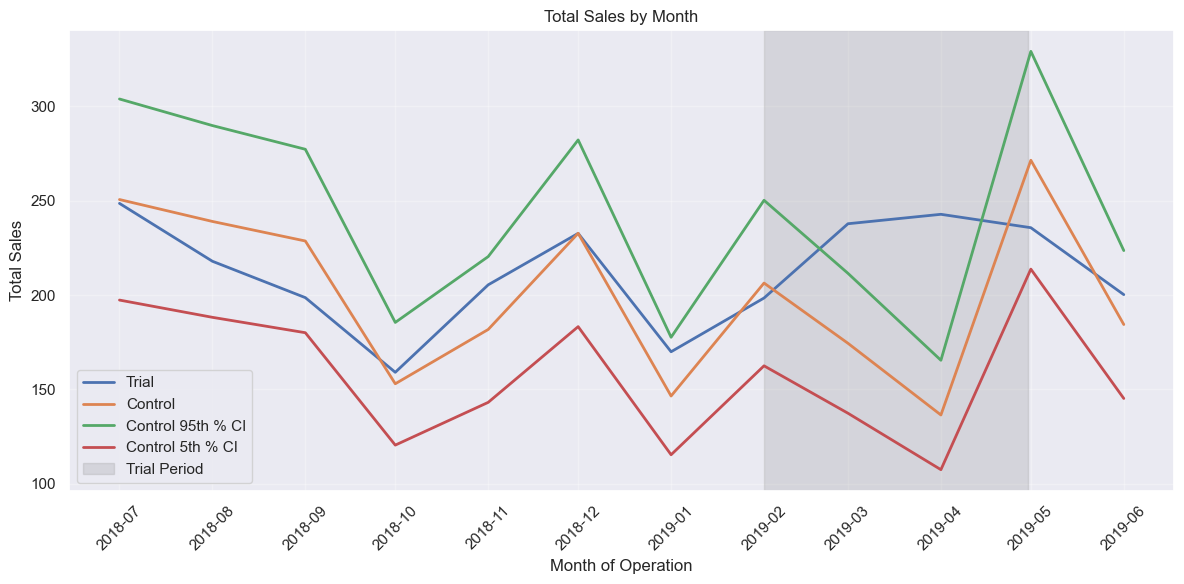

In [19]:
# Ensure agg_df has datetime ID_MONTH
if not pd.api.types.is_datetime64_any_dtype(agg_df['ID_MONTH']):
    agg_df['ID_MONTH'] = pd.to_datetime(agg_df['ID_MONTH'].astype(str), format='%Y%m')

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="TOTAL_SALES")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

plot_trial_vs_control(agg_df, trial_store=trial_store, control_store=control_store, metric_col="TOTAL_SALES")

### Number of Customers Analysis

In [20]:
trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="NUM_CUSTOMERS")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

    ID_MONTH  NUM_CUSTOMERS_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01                   36          35.856         0.401606   0.208378   
1 2019-03-01                   43          30.876        39.266744  20.374022   
2 2019-04-01                   44          23.904        84.069612  43.620528   

   Significant  
0        False  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


    ID_MONTH  NUM_CUSTOMERS_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01                   36          35.856         0.401606   0.208378   
1 2019-03-01                   43          30.876        39.266744  20.374022   
2 2019-04-01                   44          23.904        84.069612  43.620528   

   Significant  
0        False  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


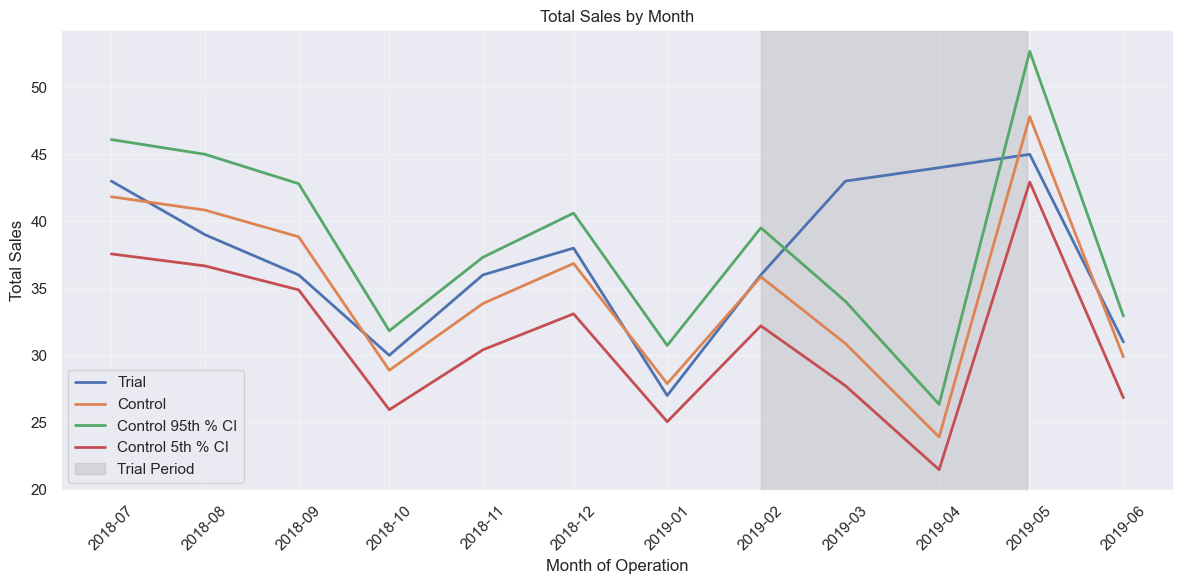

In [21]:
# Ensure agg_df has datetime ID_MONTH
if not pd.api.types.is_datetime64_any_dtype(agg_df['ID_MONTH']):
    agg_df['ID_MONTH'] = pd.to_datetime(agg_df['ID_MONTH'].astype(str), format='%Y%m')

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="NUM_CUSTOMERS")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

plot_trial_vs_control(agg_df, trial_store=trial_store, control_store=control_store, metric_col="NUM_CUSTOMERS")

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime

def plot_trial_vs_control_2(data, trial_store, control_store, metric_col, 
                         trial_start=datetime(2019, 2, 1), trial_end=datetime(2019, 4, 30)):
    # Ensure ID_MONTH is datetime
    df = data.copy()
    if not pd.api.types.is_datetime64_any_dtype(df['ID_MONTH']):
        df['ID_MONTH'] = pd.to_datetime(df['ID_MONTH'].astype(str), format='%Y%m')
    
    # Convert trial dates to datetime if they're integers
    if isinstance(trial_start, int):
        trial_start = datetime.strptime(str(trial_start), '%Y%m')
    if isinstance(trial_end, int):
        trial_end = datetime.strptime(str(trial_end), '%Y%m')
    
    # Calculate pre-trial period
    pre_start = df['ID_MONTH'].min()
    pre_end = trial_start - pd.DateOffset(months=1)
    
    # Calculate scaling factor
    scaling_factor = calculate_scaling_factor(
        df, trial_store, control_store, metric_col, pre_start, pre_end
    )
    
    # Get all months data for both stores
    trial_data = df[df['STORE_NBR'] == trial_store].copy()
    control_data = df[df['STORE_NBR'] == control_store].copy()
    
    # Scale control data
    control_data['SCALED_SALES'] = control_data[metric_col] * scaling_factor
    
    # Calculate std deviation from pre-trial period
    pre_trial_diff = calculate_percentage_diff(
        df, trial_store, control_store, metric_col, scaling_factor, pre_start, pre_end
    )
    std_dev = pre_trial_diff['PERCENTAGE_DIFF'].std() / 100  # Convert percentage to decimal
    
    # Prepare data for plotting
    plot_df = pd.concat([
        trial_data[['ID_MONTH', metric_col]].assign(Store_type='Trial'),
        control_data[['ID_MONTH', 'SCALED_SALES']].rename(
            columns={'SCALED_SALES': metric_col}
        ).assign(Store_type='Control')
    ])
    
    # Calculate confidence intervals
    control_95 = control_data[['ID_MONTH', 'SCALED_SALES']].copy()
    control_95[metric_col] = control_95['SCALED_SALES'] * (1 + 2 * std_dev)
    control_95['Store_type'] = 'Control 95th % CI'
    
    control_5 = control_data[['ID_MONTH', 'SCALED_SALES']].copy()
    control_5[metric_col] = control_5['SCALED_SALES'] * (1 - 2 * std_dev)
    control_5['Store_type'] = 'Control 5th % CI'
    
    plot_df = pd.concat([plot_df, control_95, control_5])
    
    # Create figure and axis with white background
    fig, ax = plt.subplots(figsize=(16, 9))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    ax.set_ylabel("Number of Customers")
    
    # Define colors using crest palette for control items
    crest_pal = sns.color_palette("crest", 3)
    colors = {
        'Trial': '#f4d35e',  # Gold color for trial
        'Control': crest_pal[0],
        'Control 95th % CI': crest_pal[1],
        'Control 5th % CI': crest_pal[2]
    }
    
    # Plot lines for each store type with consistent width
    for store_type in plot_df['Store_type'].unique():
        subset = plot_df[plot_df['Store_type'] == store_type]
        ax.plot(subset['ID_MONTH'], subset[metric_col], 
               color=colors[store_type], linewidth=3)
    
    # Add horizontal black line along x-axis
    ax.axhline(y=0, color='black', linewidth=1, linestyle='-', zorder=1)
    
    # Highlight trial period with grey box
    ax.axvspan(trial_start, trial_end, alpha=0.10, color='grey', zorder=0)
    
    # Set y-axis limits
    ax.set_ylim(0, 70)
    
    # Format x-axis to show month abbreviations
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
    
    # Create custom legend boxes (Control, Control 95th % CI, Control 5th % CI, Trial Period)
    legend_items = [
        ('Control', crest_pal[0]),
        ('Control 95th % CI', crest_pal[1]),
        ('Control 5th % CI', crest_pal[2]),
        ('Trial Period', '#f4d35e')
    ]
    
    box_w, box_h, spacing = 0.10, 0.06, 0.007
    start_x = (1 - (len(legend_items) * box_w + (len(legend_items)-1) * spacing)) / 2
    legend_y = -0.18
    
    for i, (label, color) in enumerate(legend_items):
        ax.add_patch(mpatches.FancyBboxPatch(
            (start_x + i * (box_w + spacing), legend_y),
            box_w, box_h,
            boxstyle="round,pad=0.002",
            facecolor=color,
            edgecolor="none", 
            transform=ax.transAxes,
            clip_on=False
        ))
        text_color = 'white' if label != 'Trial Period' else 'black'
        ax.text(start_x + i * (box_w + spacing) + box_w / 2,
                legend_y + box_h / 2,
                label,
                va="center", ha="center",
                fontsize=9,
                color=text_color,
                weight='bold',
                transform=ax.transAxes,
                clip_on=False)
    
    # Remove grid and extra spines, but keep the bottom spine
    ax.grid(False)
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    
    # Ensure bottom spine is visible and black
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(1)
    
    # Adjust layout to make room for legend
    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.show()

    # fig.savefig("Trial for Number of Customers",
    #         dpi=300,                            # image resolution
    #         bbox_inches=None,                # trim extra whitespace
    #         pad_inches=0.02,                    # small padding
    #         transparent=True) 

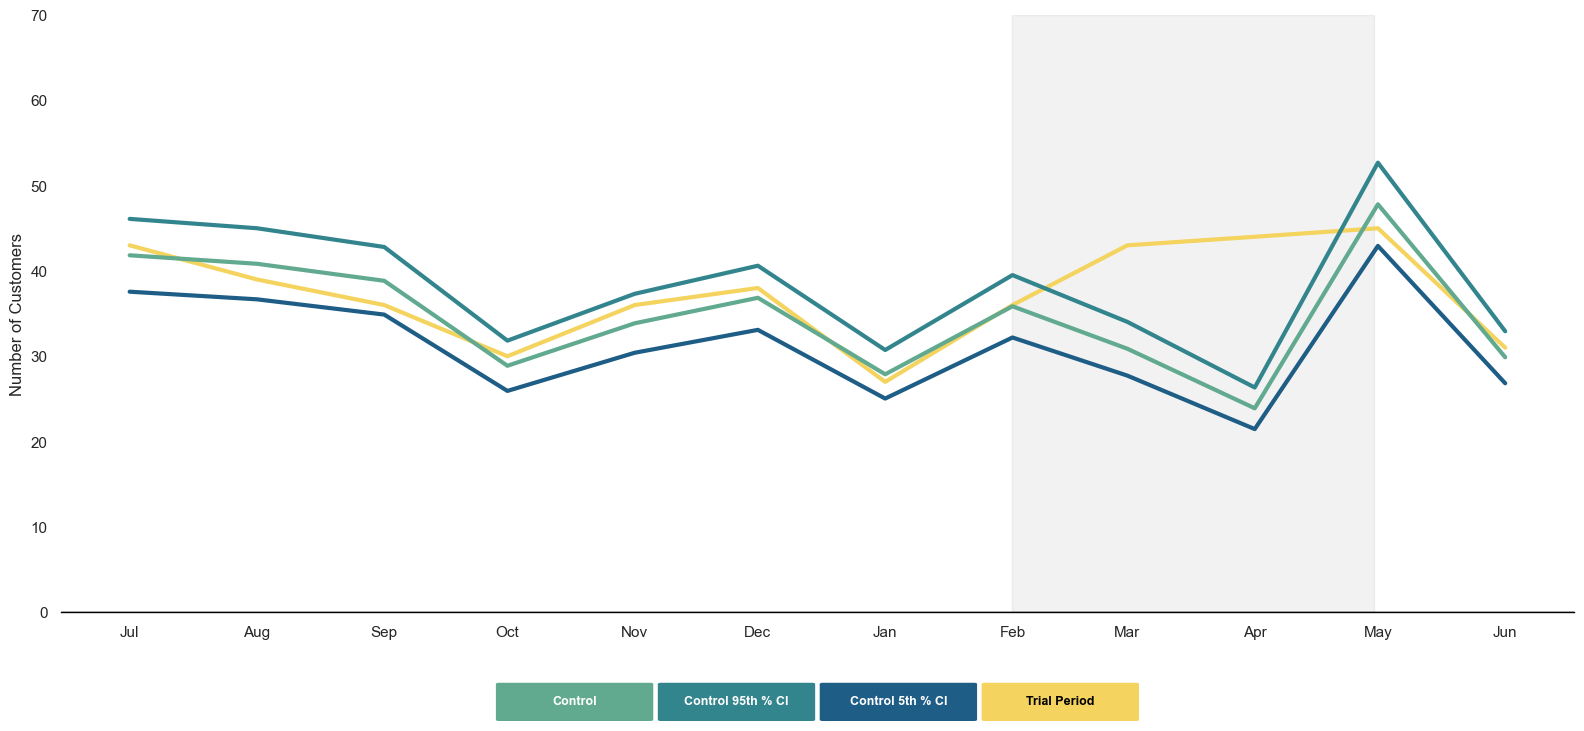

In [23]:
plot_trial_vs_control_2(agg_df, trial_store=trial_store, control_store=control_store, metric_col="NUM_CUSTOMERS")

## Store 86

In [24]:
similarity_table = calculate_similarity(pre_trial_measures, "TOTAL_SALES", store_comparison=86, corr_weight=0.5)
similarity_table = similarity_table.sort_values("score", ascending=False)
print(similarity_table.head())

     Store1  Store2  corr_measure  magnitude_similarity     score
129      86     138      0.880774              0.644895  0.762834
146      86     155      0.850729              0.628771  0.739750
245      86     260      0.735116              0.638659  0.686888
4        86       5      0.753203              0.591200  0.672202
138      86     147      0.783666              0.559066  0.671366


In [25]:
similarity_table = calculate_similarity(pre_trial_measures, "NUM_CUSTOMERS", store_comparison=86, corr_weight=0.5)
similarity_table = similarity_table.sort_values("score", ascending=False)
print(similarity_table.head())

     Store1  Store2  corr_measure  magnitude_similarity     score
146      86     155      0.761268              0.612245  0.686756
129      86     138      0.748437              0.614286  0.681361
196      86     208      0.697241              0.636364  0.666802
163      86     172      0.639737              0.628571  0.634154
211      86     225      0.582985              0.657143  0.620064


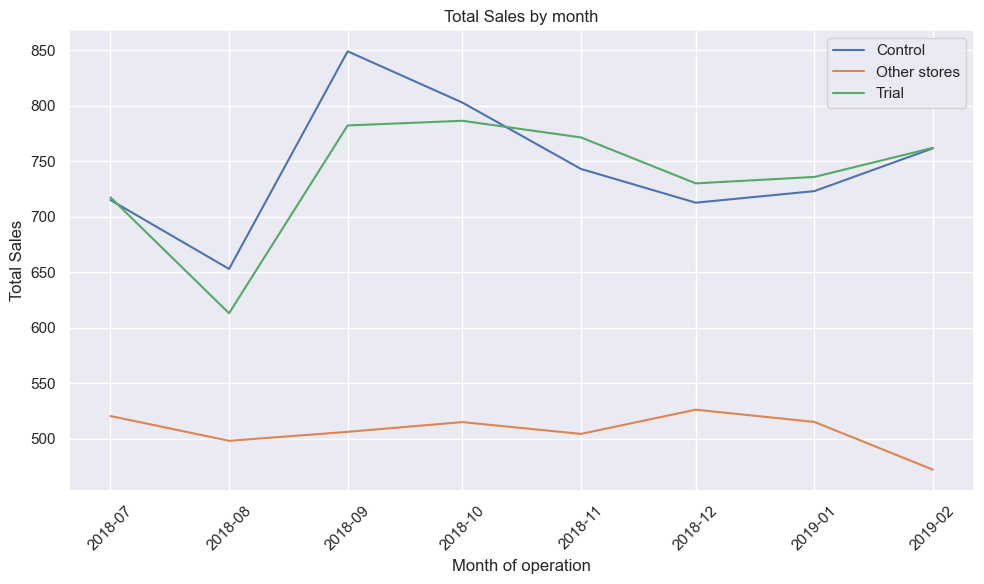

In [26]:
plot_store_comparison(agg_df, trial_store=86, control_store=155, metric_col="TOTAL_SALES")

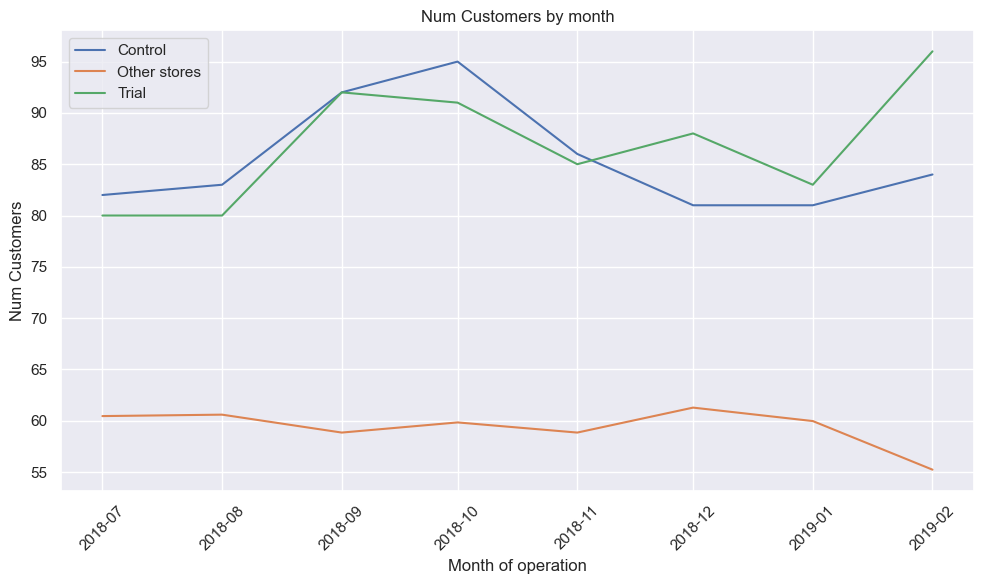

In [27]:
plot_store_comparison(agg_df, trial_store=86, control_store=155, metric_col="NUM_CUSTOMERS")

### Total Sales 86 Analysis

In [28]:
trial_store = 86
control_store = 155

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="TOTAL_SALES")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

    ID_MONTH  TOTAL_SALES_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01              762.0      752.494439         1.263207   0.741614   
1 2019-03-01              846.0      649.935454        30.166772  17.710559   
2 2019-04-01              739.4      665.151334        11.162673   6.553475   

   Significant  
0        False  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


    ID_MONTH  TOTAL_SALES_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01              762.0      752.494439         1.263207   0.741614   
1 2019-03-01              846.0      649.935454        30.166772  17.710559   
2 2019-04-01              739.4      665.151334        11.162673   6.553475   

   Significant  
0        False  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


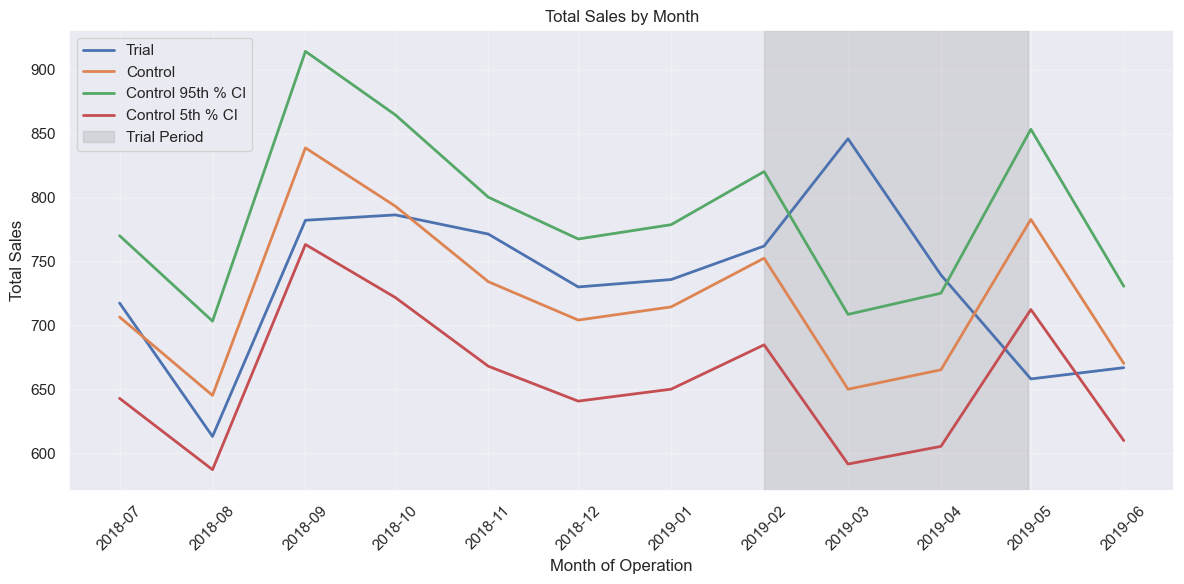

In [29]:
# Ensure agg_df has datetime ID_MONTH
if not pd.api.types.is_datetime64_any_dtype(agg_df['ID_MONTH']):
    agg_df['ID_MONTH'] = pd.to_datetime(agg_df['ID_MONTH'].astype(str), format='%Y%m')

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="TOTAL_SALES")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

plot_trial_vs_control(agg_df, trial_store=trial_store, control_store=control_store, metric_col="TOTAL_SALES")

### Number of Customers 86 Analysis

In [30]:
trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="NUM_CUSTOMERS")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

    ID_MONTH  NUM_CUSTOMERS_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01                   96       83.860000        14.476508   8.591053   
1 2019-03-01                   99       81.863333        20.933263  12.422800   
2 2019-04-01                   93       77.870000        19.429819  11.530584   

   Significant  
0         True  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


    ID_MONTH  NUM_CUSTOMERS_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01                   96       83.860000        14.476508   8.591053   
1 2019-03-01                   99       81.863333        20.933263  12.422800   
2 2019-04-01                   93       77.870000        19.429819  11.530584   

   Significant  
0         True  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


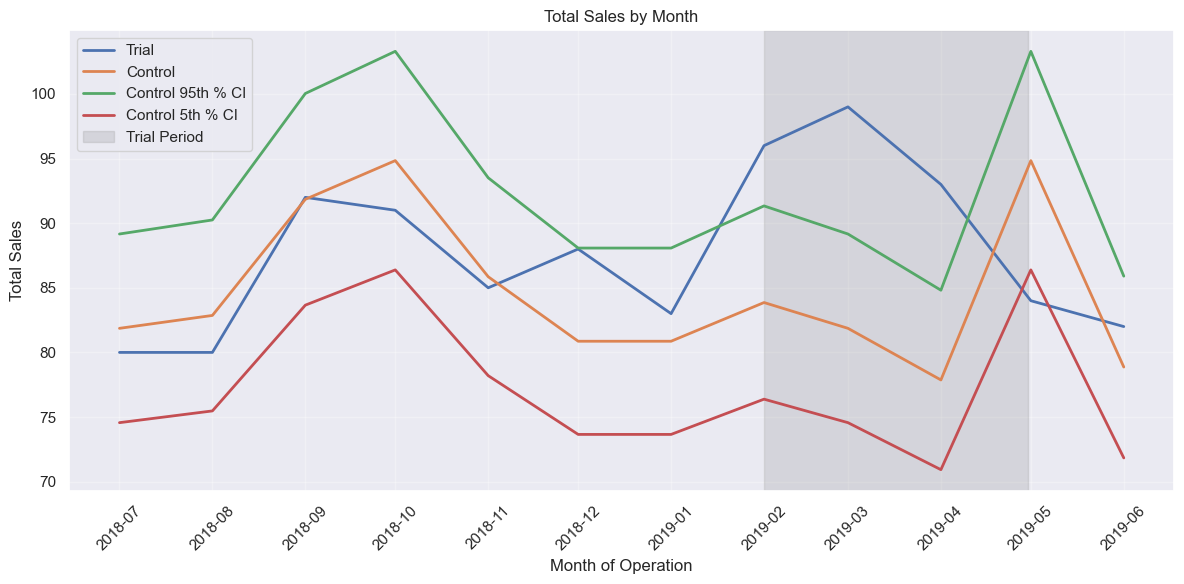

In [31]:
# Ensure agg_df has datetime ID_MONTH
if not pd.api.types.is_datetime64_any_dtype(agg_df['ID_MONTH']):
    agg_df['ID_MONTH'] = pd.to_datetime(agg_df['ID_MONTH'].astype(str), format='%Y%m')

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="NUM_CUSTOMERS")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

plot_trial_vs_control(agg_df, trial_store=trial_store, control_store=control_store, metric_col="NUM_CUSTOMERS")

## STORE 88

In [32]:
similarity_table_sales = calculate_similarity(pre_trial_measures, "TOTAL_SALES", store_comparison=88, corr_weight=0.5)
similarity_table_sales = similarity_table_sales.sort_values("score", ascending=False)
print(similarity_table_sales.head())

     Store1  Store2  corr_measure  magnitude_similarity     score
193      88     204      0.924767              0.651547  0.788157
146      88     155      0.777735              0.673906  0.725820
211      88     225      0.920955              0.517974  0.719465
0        88       1      0.889578              0.485443  0.687511
226      88     240      0.806961              0.508197  0.657579


In [33]:
similarity_table_cus = calculate_similarity(pre_trial_measures, "NUM_CUSTOMERS", store_comparison=88, corr_weight=0.5)
similarity_table_cus = similarity_table_cus.sort_values("score", ascending=False)
print(similarity_table_cus.head())

     Store1  Store2  corr_measure  magnitude_similarity     score
53       88      57      0.839317              0.703297  0.771307
32       88      35      0.829400              0.685714  0.757557
72       88      77      0.883831              0.607143  0.745487
219      88     233      0.874258              0.600000  0.737129
110      88     119      0.808093              0.642857  0.725475


In [34]:
# Get the top stores from each similarity table
top_sales_stores = similarity_table_sales.head(20)['Store2'].tolist()
top_cus_stores = similarity_table_cus.head(20)['Store2'].tolist()

# Find common stores between the top of both lists
common_stores = set(top_sales_stores) & set(top_cus_stores)

if common_stores:
    # Get the best common store (the one with highest combined ranking)
    best_store = None
    best_combined_rank = float('inf')
    
    for store in common_stores:
        sales_rank = top_sales_stores.index(store) + 1
        cus_rank = top_cus_stores.index(store) + 1
        combined_rank = sales_rank + cus_rank
        
        if combined_rank < best_combined_rank:
            best_combined_rank = combined_rank
            best_store = store
    
    # Get the details for the best store from both tables
    sales_details = similarity_table_sales[similarity_table_sales['Store2'] == best_store].iloc[0]
    cus_details = similarity_table_cus[similarity_table_cus['Store2'] == best_store].iloc[0]
    
    print(f"Best matching store for both metrics: {best_store}")
    print("\nSales similarity details:")
    print(sales_details)
    print("\nCustomer similarity details:")
    print(cus_details)
else:
    print("No common stores found in the top 10 of both similarity tables.")
    # Expand search to top 20 if no common stores in top 10
    top_sales_stores = similarity_table_sales.head(40)['Store2'].tolist()
    top_cus_stores = similarity_table_cus.head(40)['Store2'].tolist()
    common_stores = set(top_sales_stores) & set(top_cus_stores)
    
    if common_stores:
        print(f"Common stores found in top 20: {common_stores}")
    else:
        print("No common stores found even in top 20.")

Best matching store for both metrics: 145

Sales similarity details:
Store1                   88.000000
Store2                  145.000000
corr_measure              0.800027
magnitude_similarity      0.353896
score                     0.576962
Name: 136, dtype: float64

Customer similarity details:
Store1                   88.000000
Store2                  145.000000
corr_measure              0.805451
magnitude_similarity      0.482143
score                     0.643797
Name: 136, dtype: float64


In [35]:
# For sales similarity
store_237_sales = similarity_table_sales[similarity_table_sales['Store2'] == 237]
position_sales = similarity_table_sales.index.get_loc(store_237_sales.index[0]) + 1
score_sales = store_237_sales['score'].iloc[0]

# For customer similarity
store_237_cus = similarity_table_cus[similarity_table_cus['Store2'] == 237]
position_cus = similarity_table_cus.index.get_loc(store_237_cus.index[0]) + 1
score_cus = store_237_cus['score'].iloc[0]

print(f"Store 237 position in sales similarity: {position_sales}, score: {score_sales}")
print(f"Store 237 position in customer similarity: {position_cus}, score: {score_cus}")

Store 237 position in sales similarity: 130, score: 0.25057107383362065
Store 237 position in customer similarity: 9, score: 0.6281508993800742


We are gonna proceed with 237 since thats what was asked!

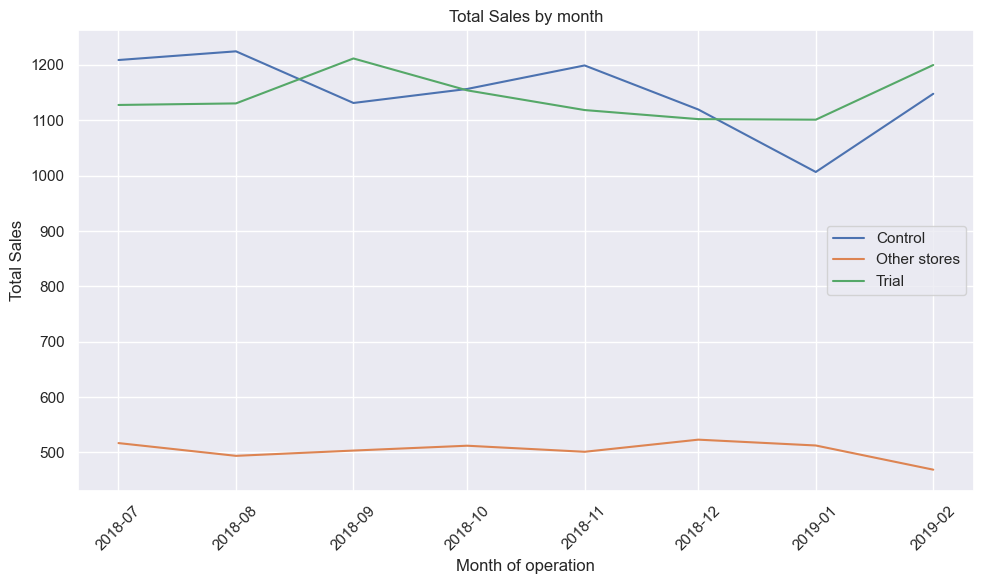

In [36]:
plot_store_comparison(agg_df, trial_store=88, control_store=237, metric_col="TOTAL_SALES")

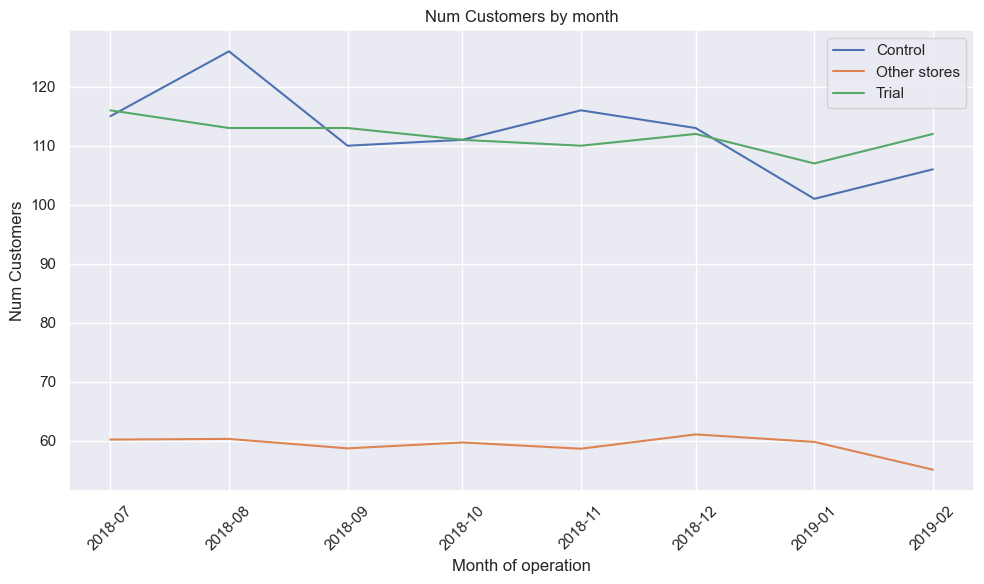

In [37]:
plot_store_comparison(agg_df, trial_store=88, control_store=237, metric_col="NUM_CUSTOMERS")

### Total Sales 88 Analysis

In [38]:
trial_store = 88
control_store = 237

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="TOTAL_SALES")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

    ID_MONTH  TOTAL_SALES_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01             1200.0     1133.605955         5.856889   2.221942   
1 2019-03-01             1354.6     1008.000835        34.384809  13.044649   
2 2019-04-01             1188.2      993.781388        19.563519   7.421860   

   Significant  
0         True  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


    ID_MONTH  TOTAL_SALES_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01             1200.0     1133.605955         5.856889   2.221942   
1 2019-03-01             1354.6     1008.000835        34.384809  13.044649   
2 2019-04-01             1188.2      993.781388        19.563519   7.421860   

   Significant  
0         True  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


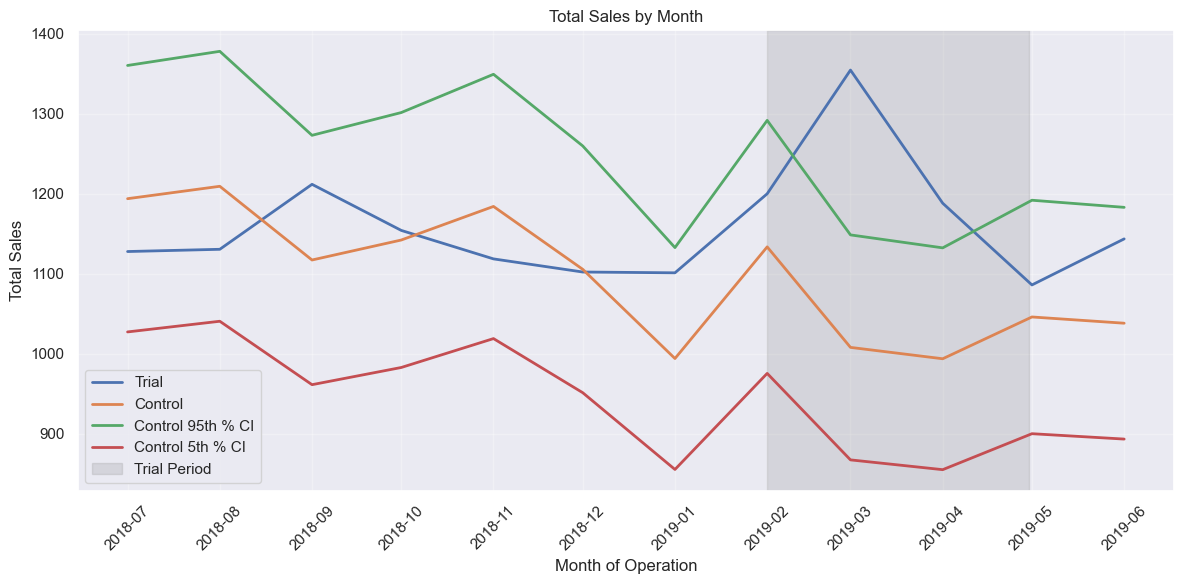

In [39]:
# Ensure agg_df has datetime ID_MONTH
if not pd.api.types.is_datetime64_any_dtype(agg_df['ID_MONTH']):
    agg_df['ID_MONTH'] = pd.to_datetime(agg_df['ID_MONTH'].astype(str), format='%Y%m')

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="TOTAL_SALES")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

plot_trial_vs_control(agg_df, trial_store=trial_store, control_store=control_store, metric_col="TOTAL_SALES")

### Number of Customers 88 Analysis

In [40]:
trial_store = 88
control_store = 237

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="NUM_CUSTOMERS")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

    ID_MONTH  NUM_CUSTOMERS_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01                  112      104.661616         7.011533   3.433080   
1 2019-03-01                  127      101.699495        24.877710  12.180953   
2 2019-04-01                  109      100.712121         8.229276   4.029327   

   Significant  
0         True  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


    ID_MONTH  NUM_CUSTOMERS_TRIAL  SCALED_CONTROL  PERCENTAGE_DIFF     tValue  \
0 2019-02-01                  112      104.661616         7.011533   3.433080   
1 2019-03-01                  127      101.699495        24.877710  12.180953   
2 2019-04-01                  109      100.712121         8.229276   4.029327   

   Significant  
0         True  
1         True  
2         True  
95th percentile t-value threshold: 1.9431802803927818


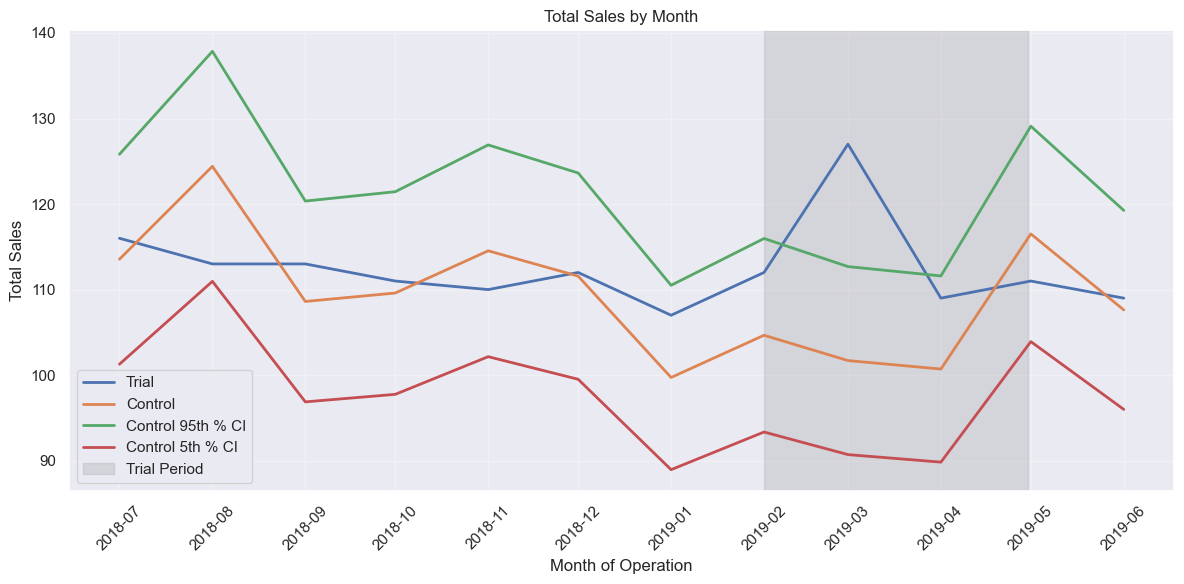

In [41]:
# Ensure agg_df has datetime ID_MONTH
if not pd.api.types.is_datetime64_any_dtype(agg_df['ID_MONTH']):
    agg_df['ID_MONTH'] = pd.to_datetime(agg_df['ID_MONTH'].astype(str), format='%Y%m')

trial_results, t_threshold, std_dev = t_test_trial_uplift(agg_df, trial_store, control_store, metric_col="NUM_CUSTOMERS")
print(trial_results)
print("95th percentile t-value threshold:", t_threshold)

plot_trial_vs_control(agg_df, trial_store=trial_store, control_store=control_store, metric_col="NUM_CUSTOMERS")